In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import copy
import time
import os

# --- 1. Konfigurasi dan Pengecekan Lingkungan ---

# Cek apakah CUDA tersedia untuk komputasi cepat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")

# Path ke gambar (sesuaikan jika perlu di lingkungan Anda)
# Kami menggunakan path yang Anda berikan.
content_path = "/content/drive/MyDrive/Deep Learning Lanjut/Pert2/Pantai.jpg"
style_path = "/content/drive/MyDrive/Deep Learning Lanjut/Pert2/api.jpg"
output_filename = "Pantai_API_Result.jpg"

# Ukuran gambar yang diinginkan (dikecilkan agar proses lebih cepat di CPU/Colab)
# Jika menggunakan GPU (CUDA), gunakan ukuran lebih besar seperti 512
imsize = 512 if torch.cuda.is_available() else 256
print(f"Ukuran gambar target: {imsize}x{imsize}")

# Berat untuk Loss Function
style_weight = 1000000.0 # Bobot tinggi untuk memaksimalkan transfer gaya
content_weight = 1.0     # Bobot rendah untuk menjaga konten
num_steps = 100          # Jumlah langkah optimasi (sesuaikan)

# Lapisan VGG yang digunakan untuk menghitung fitur
content_layers = ['conv_4'] # Biasanya lapisan tengah VGG
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # Semua lapisan untuk menangkap skala gaya yang berbeda

# --- 2. Fungsi Pemuatan Gambar dan Utilitas ---

def image_loader(image_name):
    """Memuat gambar, mengubah ukurannya, dan mengonversinya menjadi tensor."""
    if not os.path.exists(image_name):
        print(f"ERROR: File tidak ditemukan di path: {image_name}")
        # Gunakan gambar placeholder jika file tidak ditemukan
        placeholder_size = (imsize, imsize)
        image = Image.new('RGB', placeholder_size, color = 'red')
        print("Menggunakan placeholder merah. Harap periksa path Anda.")
    else:
        image = Image.open(image_name)

    # Scaler dan Konversi ke Tensor
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor()])

    # Tambahkan dimensi batch ke tensor (1 batch)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imsave(tensor, filename):
    """Mengonversi tensor kembali ke gambar PIL dan menyimpannya."""
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(filename)
    return image

# --- 3. Implementasi Loss Modules ---

# Normalisasi VGG
# Menggunakan nilai mean dan std dari model yang sudah dilatih di ImageNet
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    """Layer normalisasi untuk menyesuaikan input VGG."""
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # Ubah ukuran mean/std menjadi [C, 1, 1] agar dapat disiarkan
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    """Menghitung Mean Squared Error (MSE) antara fitur gambar input dan gambar konten."""
    def __init__(self, target_feature):
        super(ContentLoss, self).__init__()
        # Target dipisahkan dari grafik komputasi
        self.target = target_feature.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    """Menghitung Gram Matrix untuk menangkap korelasi antar fitur (tekstur/gaya)."""
    a, b, c, d = input.size()  # a=batch size(=1), b=feature maps, c,d=dimensi fitur
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t()) # Gram Product
    # Normalisasi Gram Matrix
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    """Menghitung MSE antara Gram Matrix gambar input dan gambar gaya."""
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# --- 4. Fungsi Pembentuk Model Style Transfer ---

def get_style_model_and_losses(cnn, style_img, content_img):
    """Menyisipkan layer Normalisasi dan Loss ke dalam VGG Sequential Model."""

    # Dapatkan VGG-19 yang sudah dilatih sebelumnya
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

    model = nn.Sequential(normalization)
    style_losses = []
    content_losses = []

    i = 0  # Counter untuk layer konvolusi
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False) # Gunakan ReLU non-inplace
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            # Tambahkan Content Loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Tambahkan Style Loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Hapus layer VGG yang berada setelah layer loss terakhir, karena tidak diperlukan
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

# --- 5. Fungsi Utama Style Transfer (Menggunakan L-BFGS) ---

def run_style_transfer(cnn, content_img, style_img, input_img):
    """Jalankan proses style transfer menggunakan L-BFGS."""
    print('\nMembangun model style transfer..')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)

    # Gambar input memerlukan 'requires_grad' agar dapat dioptimasi
    input_img.requires_grad_(True)

    # Optimizer L-BFGS (Limited-memory BFGS)
    # Sangat efisien untuk optimasi pixel gambar (optimasi langka)
    optimizer = optim.LBFGS([input_img])

    run = [0]
    print(f"Memulai Optimasi L-BFGS, total langkah: {num_steps}")

    start_time = time.time()
    while run[0] <= num_steps:

        # Fungsi closure adalah wajib untuk L-BFGS di PyTorch
        # Fungsi ini menghitung loss, gradien, dan mengembalikan loss.
        def closure():
            # Batasi nilai pixel ke rentang [0, 1] setelah optimasi
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            # Hitung total Style Loss dan Content Loss
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # Terapkan bobot
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward() # Hitung gradien

            run[0] += 1
            if run[0] % 50 == 0:
                elapsed = time.time() - start_time
                print('--- Langkah Optimasi ke {} (Waktu: {:.2f}s) ---'.format(run[0], elapsed))
                print('Style Loss : {:8.4f} Content Loss: {:8.4f}'.format(
                    style_score.item(), content_score.item()))

            return loss

        optimizer.step(closure)

    # Final clamp
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# --- 6. Eksekusi Utama ---

if __name__ == '__main__':
    # Memuat VGG-19 yang sudah dilatih sebelumnya
    cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

    # Memuat gambar konten dan gaya
    content_img = image_loader(content_path)
    style_img = image_loader(style_path)

    # Perhatian: Pastikan ukuran gambar sesuai
    if style_img.size() != content_img.size():
        print("PERINGATAN: Ukuran gambar konten dan gaya tidak sama. Proses tetap dilanjutkan.")

    # Gambar hasil dimulai dari gambar konten (sesuai permintaan)
    input_img = content_img.clone()

    #

    try:
        output = run_style_transfer(cnn, content_img, style_img, input_img)

        # Simpan hasil
        output_path = f"/content/drive/MyDrive/Deep Learning Lanjut/Pert2/{output_filename}"
        imsave(output, output_path)
        print(f"\n✅ Proses selesai. Gambar hasil disimpan di: {output_path}")

    except RuntimeError as e:
        print(f"\n❌ Gagal menjalankan style transfer: {e}")
        print("Mungkin terjadi kekurangan memori GPU. Coba kurangi 'imsize' atau 'num_steps'.")

Menggunakan perangkat: cuda
Ukuran gambar target: 512x512
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 71.1MB/s]



Membangun model style transfer..
Memulai Optimasi L-BFGS, total langkah: 100
--- Langkah Optimasi ke 50 (Waktu: 4.75s) ---
Style Loss : 1684.4208 Content Loss:  19.9529
--- Langkah Optimasi ke 100 (Waktu: 9.78s) ---
Style Loss : 667.0457 Content Loss:  21.3382

✅ Proses selesai. Gambar hasil disimpan di: /content/drive/MyDrive/Deep Learning Lanjut/Pert2/Pantai_API_Result.jpg


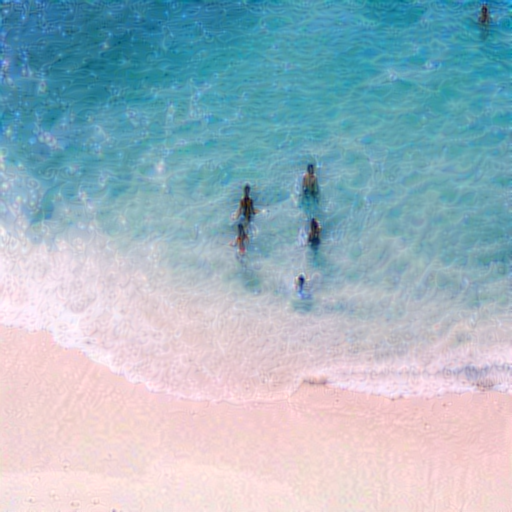